In [1]:
import time, psutil, os
_proc = psutil.Process(os.getpid())
_start_time = time.time()
_start_mem = _proc.memory_info().rss


# Random Forest K-Fold Pipeline
This notebook builds and evaluates a Random Forest classifier on the CIC‑DDoS2019 SYN‑flood subset using fixed folds.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


## Load dataset

In [4]:
CSV_PATH = 'K5_Dataset.csv'  # change if needed
df = pd.read_csv(CSV_PATH)
features = [c for c in df.columns if c not in ('Label', 'Fold')]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cross‑validation loop

In [5]:
folds = sorted(df['Fold'].unique())
accs, cms = [], None
for fid in folds:
    train = df[df['Fold'] != fid]
    test  = df[df['Fold'] == fid]
    X_tr, y_tr = train[features], train['Label']
    X_te, y_te = test[features],  test['Label']
    scaler = StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_te = scaler.transform(X_te)
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    rf.fit(X_tr, y_tr)
    accs.append(rf.score(X_te, y_te))
    cm = confusion_matrix(y_te, rf.predict(X_te))
    cms = cm if cms is None else cms + cm
print(f"Mean accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

Mean accuracy: 0.9991 ± 0.0006


## Confusion matrix

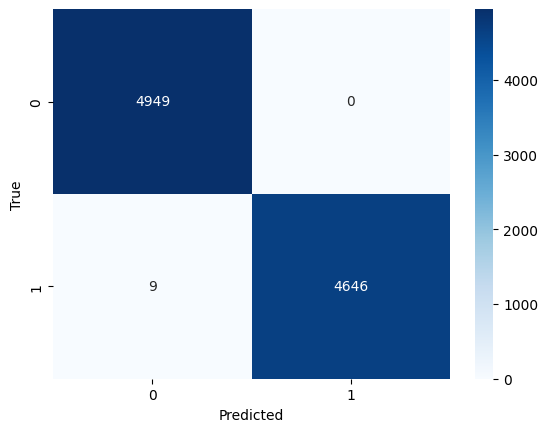

In [6]:
sns.heatmap(cms, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

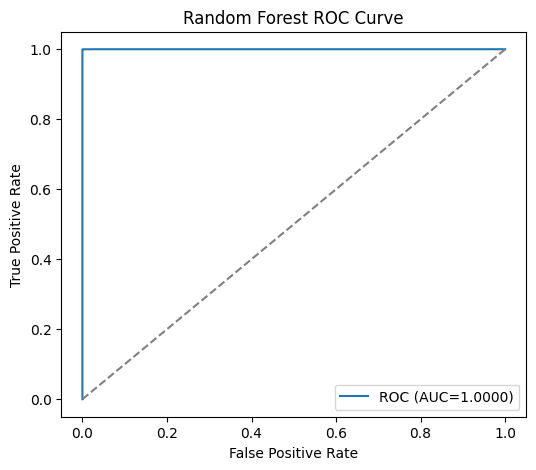

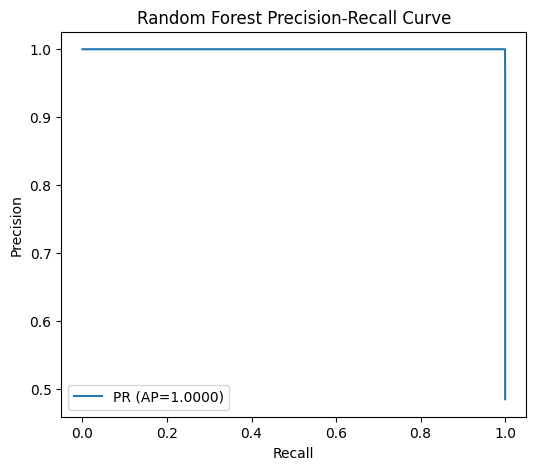

In [7]:

# ---- ROC & Precision-Recall curves for aggregated predictions ----
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

y_true_all, y_prob_all = [], []
for fid in folds:
    fold_mask = df['Fold'] == fid
    X_te = df.loc[fold_mask, features]
    y_te = df.loc[fold_mask, 'Label']
    X_te = scaler.transform(X_te)
    y_true_all.extend(y_te)
    y_prob_all.extend(rf.predict_proba(X_te)[:,1])

fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
roc_auc = roc_auc_score(y_true_all, y_prob_all)
precision, recall, _ = precision_recall_curve(y_true_all, y_prob_all)
ap = average_precision_score(y_true_all, y_prob_all)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})')
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve'); plt.legend(); plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR (AP={ap:.4f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall Curve'); plt.legend(); plt.show()


In [8]:
_end_mem = _proc.memory_info().rss
print("\nOverall Training Stats")
print(f"Total Training Time: {time.time() - _start_time:.2f} seconds")
print(f"Total RAM Usage Increase: {(_end_mem - _start_mem)/(1024**2):.2f} MB")
print(f"CPU Usage (at final check): {psutil.cpu_percent(interval=1):.1f}%")

print("\nFinal Random Forest Cross‑Validation Results:")
print(f"Fold Accuracies: {accs}")
print(f"Mean Accuracy: {np.mean(accs):.4f}")
print(f"Standard Deviation: {np.std(accs):.4f}")



Overall Training Stats
Total Training Time: 80.60 seconds
Total RAM Usage Increase: 172.93 MB
CPU Usage (at final check): 4.5%

Final Random Forest Cross‑Validation Results:
Fold Accuracies: [1.0, 0.9994794377928162, 0.9989588755856325, 0.9984383133784487, 0.9984375]
Mean Accuracy: 0.9991
Standard Deviation: 0.0006
